# Sensitivity Analysis

### Load the Model

In [1]:
import torch # Used for tensor operations
import numpy as np
import matplotlib.pyplot as plt
from models import VAE_LAFARGE # Importing VAE_LARFAGE model from models.py

# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

# Define the VAE_LAFARGE model class with fixed seed in reparameterization
class VAE_LAFARGE_Seeded(VAE_LAFARGE):
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

# Instantiate the model
model = VAE_LAFARGE_Seeded((3, 68, 68), hidden_dim=512, latent_dim=256)
model_path = 'trained_models/VAE_LAFARGE_latent256_mean_best_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

VAE_LAFARGE_Seeded(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(256, eps=1e

### Define Helper Functions

Modify a specific pixel

In [2]:
# Function to modify a specific pixel
def modify_pixel(image, x, y, new_value):
    modified_image = image.copy()
    modified_image[x, y] = new_value
    return modified_image

Process the image through the model

In [3]:
# Function to process the image through the model
def process_image(image, model):
    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())
    
    # Convert to tensor and add batch dimension
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    # Pass through the model
    with torch.no_grad():
        output = model(image_tensor)
    
    # Convert the output to numpy array
    reconstructed_image = output['x_hat'].squeeze().permute(1, 2, 0).numpy()
    return reconstructed_image


### Load and Analyze the Image

In [4]:
# Load the original image
image_path = 'data_subset/DMSO/B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72_0.npy' # The chosen image is randomly selected
image = np.load(image_path)

# Print image statistics
print(f"Image shape: {image.shape}")
print(f"Data type: {image.dtype}")
print(f"Min value: {image.min()}")
print(f"Max value: {image.max()}")

Image shape: (68, 68, 3)
Data type: uint16
Min value: 704
Max value: 12960


In [5]:
# Normalize the image for display
normalized_image = (image - image.min()) / (image.max() - image.min()) # Scale the image to [0, 1]

### Modify and Process the Image

In [6]:
# Modify a specific pixel (change as needed)
x, y = 30, 30  # Pixel coordinates
new_value = [0, 0, 0]  # New color value (change as needed)
modified_image = modify_pixel(image, x, y, new_value)

In [7]:
# Process the original and modified images
original_output = process_image(image, model)
modified_output = process_image(modified_image, model)

In [8]:
# Normalize the modified image for display
normalized_modified_image = (modified_image - modified_image.min()) / (modified_image.max() - modified_image.min()) # Scale the image to [0, 1]

### Visualize the Results

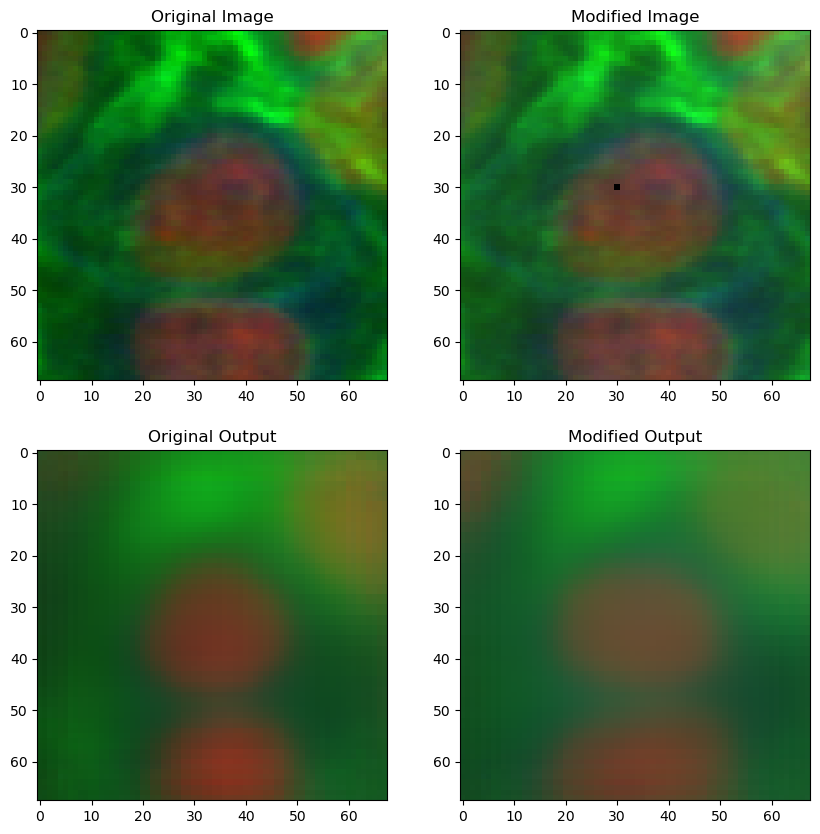

In [9]:
# Visualize the original, modified images and their outputs
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(normalized_image)
axs[0, 0].set_title('Original Image')

# Modified Image
axs[0, 1].imshow(normalized_modified_image)
axs[0, 1].set_title('Modified Image')

# Original Output
axs[1, 0].imshow(original_output)
axs[1, 0].set_title('Original Output')

# Modified Output
axs[1, 1].imshow(modified_output)
axs[1, 1].set_title('Modified Output')

plt.show()

### Sensitivity Analysis Heatmap

Compute and Visualize the Sensitivity Heatmap

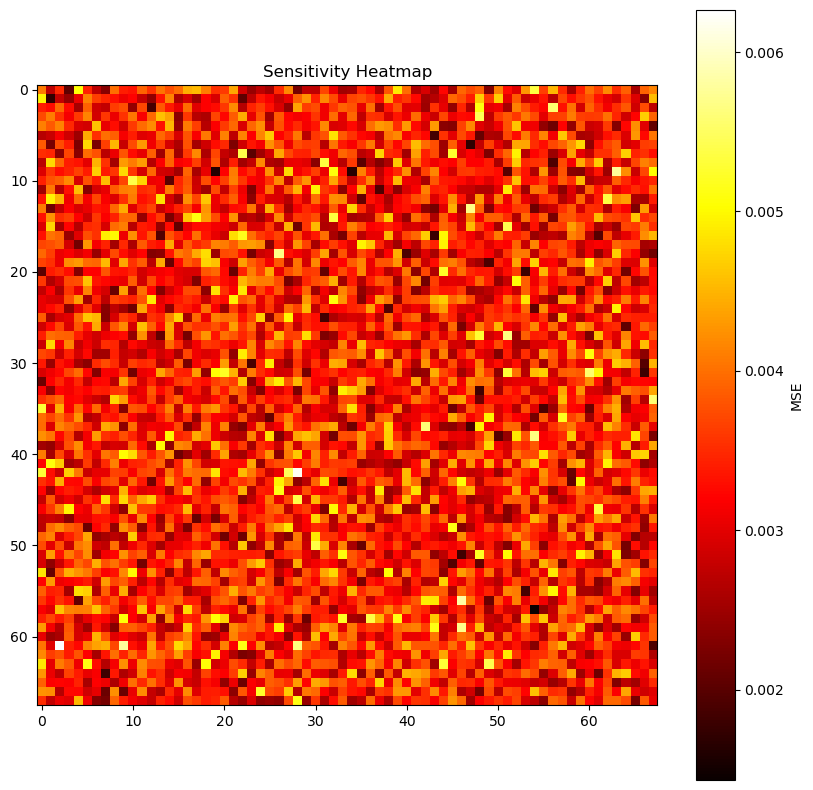

In [10]:
from sklearn.metrics import mean_squared_error # Import the mean squared error function

# Function to compute the MSE between two images
def compute_mse(image1, image2):
    return mean_squared_error(image1.flatten(), image2.flatten())

# Initialize a list to store the MSE values
mse_values = []

# Iterate over a range of pixels
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        # Modify a specific pixel
        modified_image = modify_pixel(image, i, j, [0, 0, 0])
        
        # Process the modified image
        modified_output = process_image(modified_image, model)
        
        # Compute the MSE between the original and modified outputs
        mse = compute_mse(original_output, modified_output)
        
        # Append the MSE value to the list
        mse_values.append((i, j, mse))

# Convert the list to a numpy array for easier processing
mse_array = np.array(mse_values)

# Reshape the MSE array to match the image dimensions
mse_image = mse_array[:, 2].reshape(image.shape[0], image.shape[1])

# Visualize the MSE values as a heatmap
plt.figure(figsize=(10, 10))
plt.imshow(mse_image, cmap='hot', interpolation='nearest')
plt.title('Sensitivity Heatmap')
plt.colorbar(label='MSE')
plt.show()